Вечканов Александр Анатольевич

89122795209 (telegram, whatsapp)

https://hh.ru/resume/06220d66ff0527f27a0039ed1f397075593632 

1.	Необходимо написать скрипт для парсинга диалогов из файла test_data.csv. Получившийся скрипт необходимо выложить в гит репозиторий и прислать ссылку в качестве результата прохождения тестового задания. Данные выкладывать в гит не следует. 
2.	Главные задачи, которые должен выполнять скрипт:
* a.	Извлекать реплики с приветствием – где менеджер поздоровался. 
* b.	Извлекать реплики, где менеджер представил себя. 
* c.	Извлекать имя менеджера. 
* d.	Извлекать название компании. 
* e.	Извлекать реплики, где менеджер попрощался.
Проверять требование к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»


# Устанавливаем необходимые библиотеки

При необходимости запустить ячейку

# Импортируем необходимые библиотеки

In [1]:
import pandas as pd

from natasha import (
    Segmenter, # сегментация
    MorphVocab,


    NewsEmbedding,
    NewsMorphTagger, # морфология
    NewsSyntaxParser, # синтаксис
    NewsNERTagger, # представление имен сущностей

    PER,   # извлечение именннованых сущностей
    NamesExtractor,

    Doc
)



Изменим стандартные настройки, используем максимальную ширину колонки, что бы видеть наглядно текст диалога

In [2]:
pd.set_option('display.max_colwidth', None) 

# Импортируем данные в dataframe 

In [3]:
df = pd.read_csv('test_data.csv')

In [4]:
df.head()

,dlg_id,line_n,role,text
0,0,0,client,Алло
1,0,1,manager,Алло здравствуйте
2,0,2,client,Добрый день
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается
4,0,4,client,Ага


In [5]:
print('Информация о таблице: \n')
df.info()

print('\nКол-во диалогов и объем: \n', df['dlg_id'].value_counts())

print('\nКол-во участников: \n', df['role'].value_counts())


Информация о таблице: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dlg_id  480 non-null    int64 
 1   line_n  480 non-null    int64 
 2   role    480 non-null    object
 3   text    480 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.1+ KB

Кол-во диалогов и объем: 
 5    143
0    109
2     85
1     55
3     53
4     35
Name: dlg_id, dtype: int64

Кол-во участников: 
 client     279
manager    201
Name: role, dtype: int64


**Вывод:**
    
    1) Нет пропусков в данных. 
    2) Кол-во дилогов 5. Самый большой 5-ый.
    3) Кол-во участников диалога менеджер и клиент.
    4) Кол-во фраз клиент - 279, менеджер - 201.
    
    Данный диалог думаю выгружен с телефонных переговоров поддержки, отсутствуют знаки препинания, заглавные буквы только в начале текста.

# Попробуем извлечь имена менеджеров с помощью NamesExtractor библиотеки Natasha

Сделаем сначала на тестовом предложении

In [6]:
text_test = 'Улыбок тебе дед Макар Макарович Макаров из компании Газпром и петр петрович петухов из компании газпром'
doc=Doc(text_test)

emb = NewsEmbedding()  

segmenter = Segmenter() 
ner_tagger = NewsNERTagger(emb)

doc.segment(segmenter) # делим на токены
# print(doc)

doc.tag_ner(ner_tagger) # извлекаем именннованые сущности
# print(doc.ner.print())

morph_vocab = MorphVocab() # импортируем модуль морф разбора


names_extractor = NamesExtractor(morph_vocab) # импортируем модуль нормирования имени
# doc.spans[0].type

for span in doc.spans: # приводим к нормальному виду именнованные сущности
    span.normalize(morph_vocab) 


for span in doc.spans:
    if span.type == PER:
        span.extract_fact(names_extractor)       

names_managers = {span.normal: span.fact.as_dict for span in doc.spans if span.type == PER} 
print(names_managers)

print(doc.ner.print()) # Посмотрим как определит у нас Компанию 

# нет имен с заглавной буквы...поэтому не видит...

{'Макар': {'first': 'Макар'}, 'Макарович Макаров': {'first': 'Макаров', 'last': 'Макарович'}}
Улыбок тебе дед Макар Макарович Макаров из компании Газпром и петр 
                PER── PER──────────────             ORG────        
петрович петухов из компании газпром
None


**Вывод**

    Как видим Natasha не виидит имена написанные со строчной буквы... и не определяет компании со строчной буквы, а если компания неизвестная, типа Диджитал, то он определит ее как персона...
    В общем и целом данная библиотека нас не спасёт, и будем вытаскивать нужные нам слова по "жестким правилам"

# Извлечем имена менеджеров по жестким правилам:

Этот метод конечно не удобный, но выбора нет или он мне неизвестен 

In [7]:
# Оставим в нашем датасете только слова менеджеров
df_text = df.query('role=="manager"')

In [8]:
def name_manager(row):
    
    text = row['text']
    
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb) # метод морф разбора
    
    doc=Doc(text) # создадим doc для работы
    doc.segment(segmenter) # разделим на сегменты
    doc.tag_morph(morph_tagger) # Проведем морфологический разбор слов

    for token in doc.tokens:
        token.lemmatize(morph_vocab) # Проведем лемматизацию токенов:

    for i in range(len([token.lemma for token in doc.tokens])): # передерем токены

        if [token.lemma for token in doc.tokens][i] == 'я':
            
            if [token.pos for token in doc.tokens][i+1] != 'VERB':
                return([token.lemma for token in doc.tokens][i+1])
            
            elif [token.pos for token in doc.tokens][i+1] == 'VERB':
                return([token.lemma for token in doc.tokens][i+2])

            

                        
df['name'] = df_text.apply(name_manager, axis=1)

text = 'Меня зовут ангелина компания диджитал меня марина зовут'
    
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb) # метод морф разбора
    
doc=Doc(text) # создадим doc для работы
doc.segment(segmenter) # разделим на сегменты
doc.tag_morph(morph_tagger) # Проведем морфологический разбор слов

for token in doc.tokens:
    token.lemmatize(morph_vocab) # Проведем лемматизацию токенов:

for i in range(len([token.lemma for token in doc.tokens])): # передерем токены

    if [token.lemma for token in doc.tokens][i] == 'я' or [token.lemma for token in doc.tokens][i] == 'это':
        
        if [token.pos for token in doc.tokens][i+1] != 'VERB':
            print([token.lemma for token in doc.tokens][i+1])
            
        elif [token.pos for token in doc.tokens][i+1] == 'VERB':
            print([token.lemma for token in doc.tokens][i+2])


df.query('dlg_id==5').head(10)

In [9]:
df['name'].unique()

array([nan, None, 'ангелина', 'внимание', 'данный', 'тогда', 'просто',
       'вы', 'этот', 'еще', 'ну', 'бы', 'аналитик', 'максим', 'мой',
       'вот', 'что', 'я', 'не', 'уже', 'ваш', 'правильно', 'с'],
      dtype=object)

**Вывод**

    Как видим по жестким правилам тоже не получилось вытащить имена, нам нужен более уневерсалный метод

# Извлечем имена менеджеров с помощью датасета российский имен:

Загрузим датасет с именами России c сайта https://data.mos.ru/

In [10]:
df_name_m = pd.read_csv('data_name_rus_m.csv', encoding='cp1251', sep=';')
df_name_g = pd.read_csv('data_name_rus_g.csv', encoding='cp1251', sep=';')
df_name_m.sample(5)

df_name = pd.concat([df_name_m, df_name_g], ignore_index=True)
df_name['Имя']

0        Александр
1           Михаил
2             Иван
3           Максим
4            Артём
           ...    
18158       Медина
18159        Сумая
18160       Марина
18161      Муслима
18162        Ирина
Name: Имя, Length: 18163, dtype: object

Правратим списко имен в множество:

In [11]:
text='Меня зовут ангелина компания диджитал меня марина зовут, максим и анастасия привет ответ либо бы'

result_name=list(set(df_name['Имя'].str.lower()) & set(text.split()))
result_name

['марина', 'максим', 'ангелина', 'анастасия']

Отлично, применим этот метод, вытащим все имена

In [12]:
def name_manager_1(row):
            
    text = row['text']
    line_n = row['line_n']
    
    if line_n in [0,1,2,3]:
    
        a = list(set(df_name['Имя'].str.lower()) & set(text.split()))
        for i in a:
            return i
    
#         if len(a)>1:
#             return ('asd',a)

#         else:
#             return str(a[0])
    else:
        return None

In [13]:
df['name'] = df.apply(name_manager_1, axis=1)

In [14]:
df['name'].unique()

array([None, 'ангелина', 'дмитрий', 'максим', 'анастасия'], dtype=object)

In [15]:
df.head()

,dlg_id,line_n,role,text,name
0,0,0,client,Алло,None
1,0,1,manager,Алло здравствуйте,None
2,0,2,client,Добрый день,None
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается,ангелина
4,0,4,client,Ага,None


**Вывод**

    Проанализировав начало диалогов, мы выявили имена менеджеров, НО отделить дмитрия из этого списка  не получилось 

# Извлечем приветствие и прощание менеджеров:

Создадим списки приветствий и прощаний, используем для этого библиотек nltk: 

In [16]:
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator

synonyms = []

for syn in wordnet.synsets("hi"):
    for lm in syn.lemmas():
             synonyms.append(lm.name())

rusynonyms = []

for synonym in synonyms:
    rusynonyms.append(GoogleTranslator(source='en', target='ru').translate(synonym))

print(rusynonyms)

['привет', 'привет', 'Здравствуй', 'привет', 'как дела', 'Гавайи', 'Гавайи', 'Алоха_Стат', 'ЗДРАВСТВУЙ']


Список получаем так себе, пропишем лучше вручную самые поплярные приветсвия 

In [17]:
greetings_ = ['здрав', 'привет', 'утро']
parting_ = ['свидан', 'прощай', 'пока']

Напишем ф-ию

In [18]:
def greetings(row):
    
    text = row['text']
    
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb) # метод морф разбора
    
    doc=Doc(text) # Создадим doc для работы
    doc.segment(segmenter)
    doc.tokens

    doc.tag_morph(morph_tagger) # Проведем морфологический разбор слов

    for token in doc.tokens:
        token.lemmatize(morph_vocab) # Проведем лемматизацию текста:

    for i in range(len([_.lemma for _ in doc.tokens])): # Создадим список слово + норм форма слова
        
        for j in greetings_:

            if j in [_.lemma for _ in doc.tokens][i]: #'здравствовать':
                return [_.lemma for _ in doc.tokens][i]
                        
df['greetings'] = df_text.apply(greetings, axis=1)

df.head()

,dlg_id,line_n,role,text,name,greetings
0,0,0,client,Алло,None,NaN
1,0,1,manager,Алло здравствуйте,None,здравствовать
2,0,2,client,Добрый день,None,NaN
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается,ангелина,None
4,0,4,client,Ага,None,NaN


In [19]:
def parting(row):
    
    text = row['text']
    
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb) # метод морф разбора
    
    doc=Doc(text) # Создадим doc для работы
    doc.segment(segmenter)
    doc.tokens

    doc.tag_morph(morph_tagger) # Проведем морфологический разбор слов

    for token in doc.tokens:
        token.lemmatize(morph_vocab) # Проведем лемматизацию текста:

    for i in range(len([_.lemma for _ in doc.tokens])): # Создадим список слово + норм форма слова
        
        for j in parting_:

            if j in [_.lemma for _ in doc.tokens][i]:
                return [_.lemma for _ in doc.tokens][i] 
                        
df['parting'] = df_text.apply(parting, axis=1)

df.tail()

,dlg_id,line_n,role,text,name,greetings,parting
475,5,138,manager,По поводу виджетов и с ними уже обсудите конкретно продам,None,None,None
476,5,139,manager,Все я вам высылаю счет и с вами на связи если будут вопросы можете писать на ватсапе,None,None,None
477,5,140,client,Спасибо спасибо,None,NaN,NaN
478,5,141,client,Да да тогда созвонимся ага спасибо вам давайте,None,NaN,NaN
479,5,142,manager,Ну до свидания хорошего вечера,None,None,свидание


**Вывод**

    Удалось найти решение только дедовским способом, но метод рабочий

# Извлечем компанию, которую представляет менеджер:

Компанию будем извлекать с помощью морф разбора токенов, если после слова компания идет существительно то это наименование компании

In [20]:
def company(row):
    
    text = row['text']
    
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb) # метод морф разбора
    
    doc=Doc(text) # Создадим doc для работы
    doc.segment(segmenter)
    doc.tokens

    doc.tag_morph(morph_tagger) # Проведем морфологический разбор слов

    for token in doc.tokens:
        token.lemmatize(morph_vocab) # Проведем лемматизацию текста:

    for i in range(len([_.lemma for _ in doc.tokens])): # Создадим список слово + норм форма слова

        if [_.lemma for _ in doc.tokens][i] == 'компания' and (
                                [_.pos for _ in doc.tokens][i-1] == 'VERB' or [_.pos for _ in doc.tokens][i-1] == 'NOUN'
                                                                    ):
            return [_.lemma for _ in doc.tokens][i+1]
                       
df['company'] = df_text.apply(company, axis=1)

df.head()

# and ([_.pos for _ in doc.tokens][i+1] == 'VERB' or [_.pos for _ in doc.tokens][i+1] == 'ADV')

,dlg_id,line_n,role,text,name,greetings,parting,company
0,0,0,client,Алло,None,NaN,NaN,NaN
1,0,1,manager,Алло здравствуйте,None,здравствовать,None,None
2,0,2,client,Добрый день,None,NaN,NaN,NaN
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается,ангелина,None,None,диджитал
4,0,4,client,Ага,None,NaN,NaN,NaN


**Вывод**

    Данное решение на других диалогах будет выдавать скорей всего приличную погрешность 

# Общий вывод

In [21]:
df_total = df.pivot_table(index='dlg_id', aggfunc='count').drop(['line_n','role','text'], axis=1)
df_total

,company,greetings,name,parting
dlg_id,,,,
0,1,1,1,1
1,1,1,1,1
2,1,1,1,0
3,1,0,2,0
4,0,0,0,1
5,0,0,1,1


Тут наглядно видим, что диалог номер 0 и 1 на отлично, самый неудачный это 4-ый диалог. К сожалению в 3-ем диалоги два имени, тут ничего поделать не могу  

Посмотрим уже по именам, что да к какому диалогу принадлежит

In [22]:
for i in df_total.columns:
    display(df.pivot_table(index=['dlg_id', i], aggfunc='count').drop(['line_n','role','text'], axis=1))

,,greetings,name,parting
dlg_id,company,,,
0,диджитал,0,1,0
1,диджитал,0,1,0
2,диджитал,0,1,0
3,китобизнес,0,1,0


,,company,name,parting
dlg_id,greetings,,,
0,здравствовать,0,0,0
1,здравствовать,0,0,0
2,здравствовать,0,0,0


company  greetings  parting
dlg_id name                                  
0      ангелина         1          0        0
1      ангелина         1          0        0
2      ангелина         1          0        0
3      дмитрий          0          0        0
       максим           1          0        0
5      анастасия        0          0        0

,,company,greetings,name
dlg_id,parting,,,
0,свидание,0,0,0
1,свидание,0,0,0
4,свидание,0,0,0
5,свидание,0,0,0


   Итоги работы:
    
   Спасибо за интересное тестовое задание. Итоги работы я оцениваю на 3 балла, думаю этот вариант может сработать на других диалогах, но будет выдавать какой то процент ошибок. 
    
   Конечно можно было прописать жесткие правила, через if else, и потихоньку вычленять нужные нам слова, но всё же хотелось автоматизировать проект. С рописанными правилами очень сложно масшатбабироваться, хотя на каком то небольшом объеме это может сработать.
    
   Вообще у nlp хорошее будущее, nlp давно отнесена уже в отдельную ветку ml. Есть конечно свои сложности как и у всего, но с приходом мощных машин и новых алгоритомов обработки таких как jpt3 тексты генерируются всё более реалистечней. 
    
   Так же стоит отметить проект реплика, где приложение является другом человека. Оно и было задумано так, что Евгения "скормила" все переписки с погибшим другом, и в итоге бот генерил сообщения ей в таком же стиле, как и погибший друг. Кончено такое приложение может пригодится в психотерапии (а не только для развлечения)
    
    
   Так же прикладываю вам небольшой мем для настроения))) Спасибо

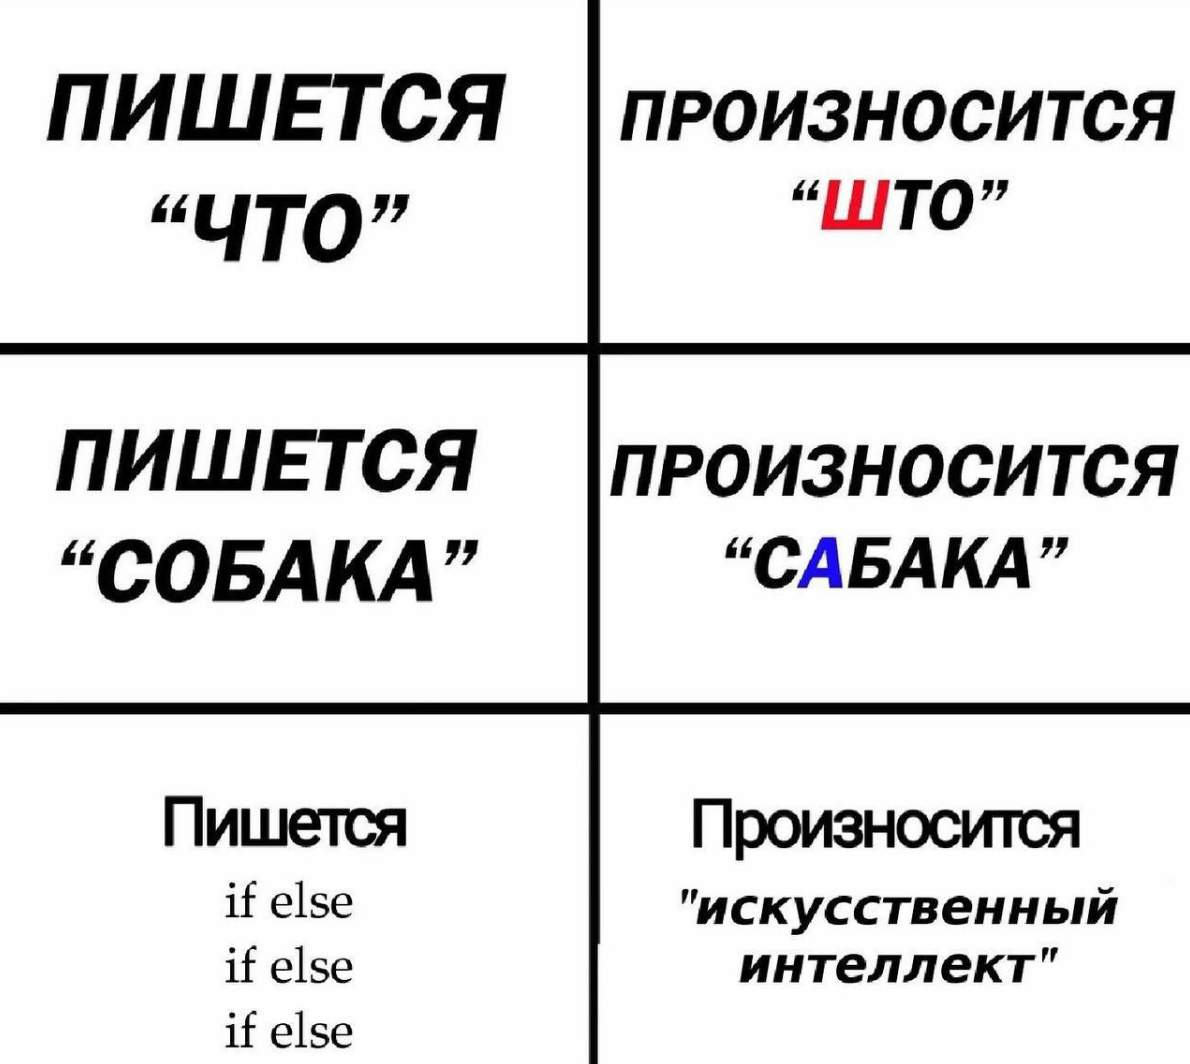

In [23]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
